### Relating G League Performance to NBA Success  
Prepared by: David L. Parks  
February 21, 2022

#### Introduction

The goal of this project is to reveal which G League performance statistics are indicative of success in the NBA. We accomplish this task using a Decision Tree Classifier to plot the path of successful players. Since success is not easily defined, we define success as any former G League player who is active in the NBA three years later. This definition and the number of years are arbitrary, but they give us a good sense of how many former G League players washout of the system after three years.

*NOTE: This notebook employs multicore processing. If your system does not have multiple cores, you MUST make changes to the cell below for the notebook to run successfully.*

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# enable multicore processing
# SET N_JOBS = 1 IF YOUR SYSTEM DOES NOT HAVE MULTIPLE CORES 
N_JOBS = 6

2018-2019 G League player performance data[[1]](https://stats.gleague.nba.com/leaders/?Season=2018-19&SeasonType=Regular%20Season) were joined with the 2021-2022 NBA season roster[[2]](https://www.nba.com/stats/players/traditional/?PerMode=Totals&sort=PTS&dir=-1) to create a dataframe with an indicator variable for active vs inactive players (i.e. 1 or 0).

In [2]:
# import the data
nba_data = pd.read_excel("nba_2021_2022_clean.xlsx")
g_league_data = pd.read_excel("g_league_2018_2019_clean.xlsx")

In [3]:
# make sure the data imported correctly
nba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   PLAYER   592 non-null    object
 1   PLAYING  592 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


In [4]:
g_league_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLAYER       261 non-null    object 
 1   GP           261 non-null    int64  
 2   MIN          261 non-null    float64
 3   PTS          261 non-null    float64
 4   FGM          261 non-null    float64
 5   FGA          261 non-null    float64
 6   FG_PCT       261 non-null    float64
 7   THREE_PM     261 non-null    float64
 8   THREE_PA     261 non-null    float64
 9   THREE_P_PCT  261 non-null    float64
 10  FTM          261 non-null    float64
 11  FTA          261 non-null    float64
 12  FT_PCT       261 non-null    float64
 13  OREB         261 non-null    float64
 14  DREB         261 non-null    float64
 15  REB          261 non-null    float64
 16  AST          261 non-null    float64
 17  STL          261 non-null    float64
 18  BLK          261 non-null    float64
 19  TOV     

In [5]:
# remove extraneous spaces in the PLAYER column so the tables will merge correctly
nba_data.PLAYER = nba_data.PLAYER.str.strip()
g_league_data.PLAYER = g_league_data.PLAYER.str.strip()

# merge the data
full_data_set = pd.merge(g_league_data, nba_data,
                         left_on="PLAYER",
                         right_on="PLAYER",
                         how="left")

# examine the full data set
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 260
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLAYER       261 non-null    object 
 1   GP           261 non-null    int64  
 2   MIN          261 non-null    float64
 3   PTS          261 non-null    float64
 4   FGM          261 non-null    float64
 5   FGA          261 non-null    float64
 6   FG_PCT       261 non-null    float64
 7   THREE_PM     261 non-null    float64
 8   THREE_PA     261 non-null    float64
 9   THREE_P_PCT  261 non-null    float64
 10  FTM          261 non-null    float64
 11  FTA          261 non-null    float64
 12  FT_PCT       261 non-null    float64
 13  OREB         261 non-null    float64
 14  DREB         261 non-null    float64
 15  REB          261 non-null    float64
 16  AST          261 non-null    float64
 17  STL          261 non-null    float64
 18  BLK          261 non-null    float64
 19  TOV     

After the merge, we see 35 non-null entries in the PLAYING column. This means that of the 261 G League players in 2018-2019, only 35 of them are actively playing in the NBA today. This is an attrition rate of approximatley 87% after three years.

To indicate the inactive players, we replace the null values with zeros.

In [6]:
# replace the nan values with 0
full_data_set = full_data_set.fillna(0)

#### Modeling

Normally we would divide the data into training and testing sets to cross-validate the predictive accuracy of our model. However, in this case, we are more interested in the structure of our model, not necessarily its predictive accuracy. We still implement cross-validation to hypertune the parameters of our model to find the best fit, but we use the entire dataset to train and validate the model.

In [7]:
# separate the features into independent and dependent variables
X = full_data_set.drop(columns=["PLAYER", "PLAYING"])
y = full_data_set.PLAYING

In [8]:
# set up a parameter grid for grid search
search_grid = {"max_depth": [1, 2, 3, 4, 5,
                             6, 7, 8, 9, 10, None]
              }

# instantiate a Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=39)

# instantiate a GridSearchCV
grid_search = GridSearchCV(dtc, search_grid,
                           cv=5, n_jobs=N_JOBS,
                           scoring="accuracy")

# conduct a grid search
grid_search.fit(X, y)

# view the results of the grid search
grid_search.best_params_

{'max_depth': 3}

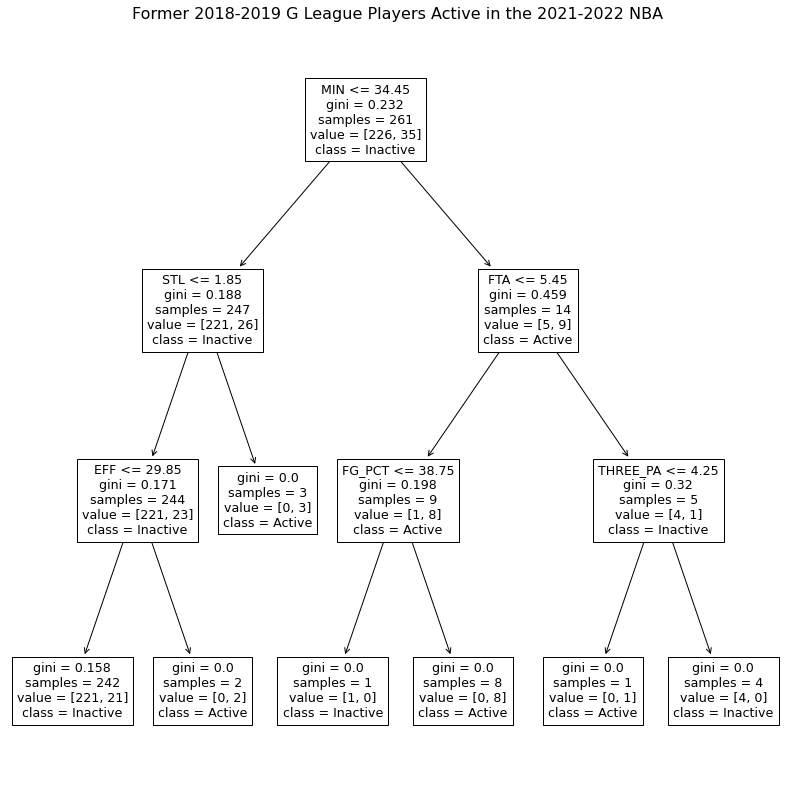

In [9]:
# instantiate and train a fresh Decision Tree
# Classifier with the optimal hyperparameters
dtc = DecisionTreeClassifier(**grid_search.best_params_, random_state=39)
dtc.fit(X, y)

# plot the decision tree
fn = X.columns
cn = ["Inactive", "Active"]
plt.figure(figsize=(14, 14))
plot_tree(dtc,
          feature_names=fn,
          class_names=cn)
plt.title("Former 2018-2019 G League Players Active in the 2021-2022 NBA", size=16);

In the tree plot above, we see the root node separates players who played <= 34.45 Minutes per Game in the G League. Following the branch down the right side, we see that of the players who played more than 34.45 Minutes per Game, 9 of them are active in the NBA today. This means that of the 35 active players, almost 25% of them are distinguished by playing time alone. Intuitively this makes sense, players who get more playing time should develop better skills and players with better skills should get more playing time. However, this leaves 26 of the active players unaccounted for, so let's take a look at the left side of the tree.

Following the branch down the left side, we see that the selection criteria for each node are Steals and Efficiency. But by the time we reach the bottom left-hand leaf, we still have a large number of inactive (221) and active (21) players unaccounted for. Even though cross-validation determined that the optimal depth of our tree is three, let's plot a new tree with max_depth=5 to see if we can shed some light on these players.

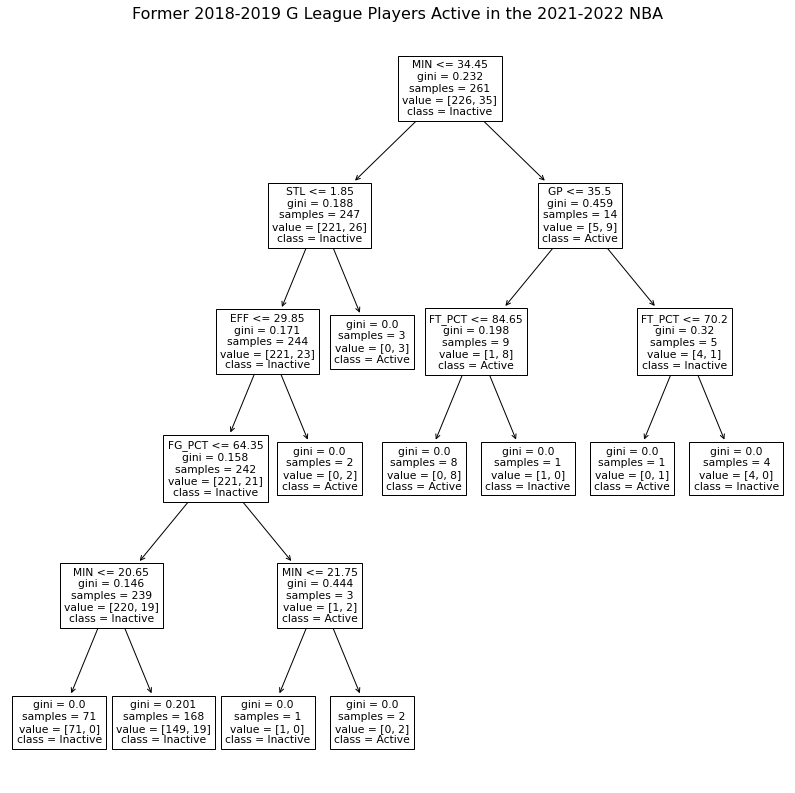

In [10]:
# instantiate and train a fresh Decision Tree
# Classifier with max_depth=5
dtc = DecisionTreeClassifier(max_depth=5, random_state=39)
dtc.fit(X, y)

# plot the decision tree
fn = X.columns
cn = ["Inactive", "Active"]
plt.figure(figsize=(14, 14))
plot_tree(dtc,
          feature_names=fn,
          class_names=cn)
plt.title("Former 2018-2019 G League Players Active in the 2021-2022 NBA", size=16);

Following the tree down the left side, we see that the next selection criteria after Efficiency is Field Goal Percent. Interestingly, after Field Goal Percent, Minutes per Game is again used to distinguish active from inactive players. In the second from the left leaf on the bottom level of the tree, we see that of the remaining 19 active players, all of them averaged more than 20.65 Minutes per Game during their 2018-2019 G League season.

Future projects should explore the relationship between Minutes per Game in the G League and success in the NBA. Timeframes other than three years should also be explored.